# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [15]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


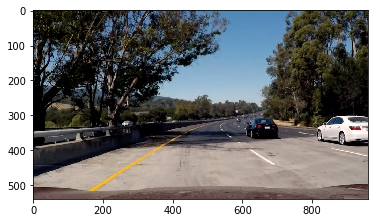

In [16]:
#reading in an image
def read_image(path):
    """Reads and returns image from the given path"""
    return mpimg.imread(path)

#printing out some stats and plotting
def read_image_and_print_dimensions(path):
    image = mpimg.imread(path)
    print('This image is:', type(image), 'with dimensions:', image.shape)
    # plt.imshow(image) 
    # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    plt.imshow(image, cmap='gray')
    return image
image = read_image_and_print_dimensions('test_images/challenge.jpg')

In [17]:
import os
from itertools import chain
from copy import deepcopy

class Lane(object):
    """
    Domain knowledge for lane recognition and lane filtering.
    We have two lanes and update them using the information we gather.
    """
    
    CRITICAL_SLOPE_CHANGE = 0.1
    MOSTLY_HORIZONTAL_SLOPE = 0.4
    MAX_SLOPE_DIFFERENCE = 0.8
    MAX_DISTANCE_FROM_LINE = 20
    BUFFER_FRAMES = 10 # The capacity of bufferred frames
    COLORS = {
        'lane_color': (255,0,0),
        'region_stable': (0,80,60),
        'region_unstable': (255,80,60),
        'left_line': (60,40,220),
        'right_line': (255,0,255)
    }
    THICKNESS = 5
    FIRST_FRAME_LINE_RANGES = {'left_line': range(480), 
                               'right_line': range(480,960)}
    
    # A decision matrix for updating a lane line in order to keep it steady.
    # A weighted average of average lane position from buffer and from the current frame.
    # 0.1 * frame position + 0.9 * avg from buffer: in case of unstable lane.
    # 1 * frame position + 0 * buffer: in case of stable lane.
    DECISION_MAT = [[.1,.9],[1,0]]
    
    left_line = None
    right_line = None
    
    @staticmethod
    def lines_exist():
        return all([lane.left_line, Lane.right_line])
    @staticmethod
    def fit_lane_line(segments):
        """
        Lines interpolation using a linear regression. Any order of polynomial can be used,
        but it should be limited with 1st here.
        """
        x, y = [], []
        
        for line in segments:
            if line.is_candidate:
                x_coordinates = list(range(line.x0, line.x1,1))
                y_coordinates = list(map(line.get_y_coordinate, x_coordinates))
                x.extend(x_coordinates)
                y.extend(y_coordinates)
                
        if x != [] and not Lane.lines_exist():
            lane_line =segments[0].lane_line
            coordinates = np.array([[x,y] for x, y in zip(x, y) 
                                    if x in Lane.FIRST_FRAME_LINE_RANGES[lane_line]])
            x = coordinates[:, 0] # [ first_row:last_row , column_0 ]
            y = coordinates[:, 1]
        if x!=[]:
            poly_coefficients = np.polyfit(x, y, 1)
            return poly_coefficients, list(zip(x, y))
        else:
            return None, None
        
    @staticmethod
    def update_vanishing_point(left_line, right_line):
        # y = mx + b
        # Set both lines equal to find the intersection point in the x direction
        # m1 * x + b1 = m2 * x + b2
        # m1 * x - m2 * x = b2 - b1
        # x * (m1 - m2) = b2 - b1
        # x = (b2 - b1) / (m1 - m2)
        equation = left_line.coefficients -right_line.coefficients
        x = - equation[1] / equation[0]
        y = np.poly1d(left_line.coefficients)(x)
        left_line.vanishing_point = [x, y]
        right_line.vanishing_point = [x, y]
        
    @staticmethod    
    def purge():
        Lane.left_line = None
        Lane.right_line = None
        
    def __init__(self, segments):
        """"""
        buffer_frames = Lane.BUFFER_FRAMES
        
        self.current_lane_line_coefficients, self.points = Lane.fit_lane_line(segments)
        
        if self.current_lane_line_coefficients is None:
            raise Exception("Can not initialize lane. No line detected!")

        # Buffer for lane line smoothing
        self.buffer = np.array(buffer_frames * [self.current_lane_line_coefficients])
        self.coefficients = self.buffer[0]
        # Indicates that if stability is used
        self.stable = True
        # Hough lines belongs to lane line
        self.segments = None
        # List of coordinates which belongs to lane line.
        self.points = None

        # Coordinates for drawing this lane line
        self.x0, self.x1, self.y0, self.y1 = 0, 0, 0, 0
    
    @property
    def slope(self):
        if len(self.coefficients) > 2:
            return Exception("Higher order polynimal for Lane.")
        return self.coefficients[0]
    
    @property
    def intercept(self):
        if len(self.coefficients) > 2:
            return Exception("Higher order polynimal for Lane.")
        return self.coefficients[1]
    
    def set_lane_line(self, segments):
        average_buffer = np.average(self.buffer, axis=0)
        self.coefficients = np.average(self.buffer, axis=0)
        self.update_current_lane_line_coefficients(segments)
        weights = Lane.DECISION_MAT[self.stable]
        import ipdb; ipdb.set_trace()
        current_buffer_coefficients = np.dot(weights,  np.vstack((self.current_lane_line_coeffs, average_buffer)))
        # Update the buffer by adding new one on the top and remove the bottom buffer in the queque
        self.buffer = np.insert(self.buffer, 0, current_buffer_coefficients, axis=0)[0:-1]
        self.update_lane_line_coordinates()
        
    def set_current_lane_line_coefficients(self, segments):
        lane_line_coefficients, points = Lane.fit_lane_line(segments)
        if lane_line_coefficients is None:
            lane_line_coefficients = np.average(self.buffer, axis=0)
        if points is not None:
            self.points = points
        average_buffer = np.average(self.buffer, axis=0)
        buffer_slope = average_buffer[0]
        current_slope = lane_line_coefficients[0]
        self.current_lane_line_coefficients = lane_line_coefficients
        self.stable = False if abs(current_slope -buffer_slope) > Lane.CRITICAL_SLOPE_CHANGE else True
        
    def set_segements(self, segments):
        self,segments = segments
         
    def get_x_coordinates(self, y):
        return int((y - self.coefficients[1]) / self.coefficients[0])
    
    def set_lane_line_coordinates(self):
        offset = 19
        self.y0 = image.shape[1]
        self.x0 = self.get_x_coordinates(self.y0)
        self.y1 = self.vanishing_point[1] + offset
        self.x1 = self.get_x_coordinates(self.y1)

In [18]:
class  Line(object):
    """
    Line : y = ax + b
    A line can be defined by coordinates pair of (x0, y0), (x1, y1).
    Given a pair of coordinates, we can compute its slope a and intercept b.
    """
    
    def __init__(self, x0, y0, x1, y1):
        if x0 > x1: (x0, y0), (x1, y1) = (x1, y1), (x0, y0)
        self.x0, self.y0 = x0, y0
        self.x1, self.y1 = x1, y1
        self.a = self.compute_slope()
        self.b = self.compute_intercept()
        self.lane_line = self.assign_to_lane_line()
        
    @property
    def is_candidate(self):
        
        """Check if a hough line can be a candidate for being a segement of a lane line.
        1. The line cannot be horizontal and have a acceptable slope
        2. The slope of the hough line should be close to the lane line's
        3. The hough line should not be far from its lane line
        4. The hough line should be below the vanishing point.
        """
        if abs(self.a < Lane.MOSTLY_HORIZONTAL_SLOPE):
            return False
        lane_line =getattr(Lane, self.lane_line)
        if lane_line:
            if abs(self.slope - lane_line.coefficients[0]) > Lane.MAX_SLOPE_DIFFERENCE:
                return False
            if self.distance_to_lane_line > Lane.MAX_DISTANCE_FROM_LINE: 
                return False
            if self.y1 < Lane.left_line.vanishing_point[1]:
                return False
        return True
    
    def assign_to_lane_line(self):
        if self.slope < 0.0: return 'left_line'
        else: return 'right_line'
        
        
    @property
    def distance_to_lane_line(self):
        lane_line = getattr(Lane, self.lane_line)
        if lane_line is None: return None
        avg_x = (self.x1 + self.x0) / 2
        avg_y = (self.y1 + self.y0) / 2
        distance = abs(lane_line.slope * avg_x - avg_y + 
                   lane_line.intercept) / math.sqrt(lane_line.slope ** 2 + 1)
        return distance

## My Own Helper Functions
Below are helper functions created myself.

In [19]:
def gimp_to_opencv_hsv(*hsv):
    """
    As I use GIMP to pick the color from image, 
    we need to convert gimp color space to CV2 HSV color space
    """
    return (hsv[0] / 2, hsv[1] / 100 * 255, hsv[2] / 100 * 255)

# A constant polygon coordinates for the region of interest
ROI_VERTICES = np.array([[(50, 540), (420, 330), (590, 330), 
                      (960 - 50, 540)]], dtype=np.int32)    

# White and yellow color thresholds for lines masking.
# Optional "kernel" is used for Morphological Transformation: Opening.
# For more information: https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html
WHITE_LINES = { 'low_th': gimp_to_opencv_hsv(0, 0, 80),
                'high_th': gimp_to_opencv_hsv(359, 10, 100) }

YELLOW_LINES = { 'low_th': gimp_to_opencv_hsv(35, 20, 30),
                 'high_th': gimp_to_opencv_hsv(65, 100, 100),
                 'kernel': np.ones((3,3),np.uint64)}   

def get_lane_line_mask(hsv_image, colors):
    masks = []
    for color in colors :
        if 'low_th' in color and 'high_th' in color:
            mask = cv2.inRange(hsv_image, color['low_th'], color['high_th'])
            if 'kernel' in color:
                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, color['kernel'])
            masks.append(mask)
        else: raise Exception("Low or high threshold values are missing")
    if masks:
        return cv2.add(*masks)

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

###### Below are some helper functions to help get you started. They should look familiar from the lesson!

In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)
def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, 
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)
    
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
    # If either array is empty, waive length requirement
    if not positive_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_points.append([x1, y1])
                    positive_slope_points.append([x2, y2])
                    positive_slope_intercept.append([slope, y1-slope*x1])
    if not negative_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_points.append([x1, y1])
                    negative_slope_points.append([x2, y2])
                    negative_slope_intercept.append([slope, y1-slope*x1])
    if not positive_slope_points:
        print("positive_slope_points still empty")
    if not negative_slope_points:
        print("negative_slope_points still empty")
    # Even though positive_slope_points is not used, I am keeping it for debugging purposes.
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)
    # print("Positive slope line points: ", positive_slope_points)
    # print("Negative slope line points: ", negative_slope_points)
    # print("positive slope points dtype: ", positive_slope_points.dtype)

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    
    # Discarded Linear Regression Option:
    # Get intercept and coefficient of linear regression lines
    # pos_coef, pos_intercept = find_linear_regression_line(positive_slope_points)
    # neg_coef, neg_intercept = find_linear_regression_line(negative_slope_points)
    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**



In [ ]:
os.listdir("test_images/")
# Read and save test images to array
test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]

## Pipeline
Steps:
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Define our parameters for Canny and apply to get edges image
4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw line segments
7. Draw lines extrapolated from line segments
8. Combine line image with original image to see how accurate the line annotations are.

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
# Pipeline

def draw_lane_lines(image):
    """Draw lane lines in white on original image."""
    # Print image details
    print("image.shape: ", image.shape)
    imshape = image.shape
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    plt.subplot(2,2,1)
    plt.imshow(greyscaled_image, cmap="gray")
    
    # chose a kernelSize of 5 for Gaussian smoothing,
    # a lowThreshold of 50 and a highThreshold of 150. 
    # These selections nicely extract the lane lines, 
    # while minimizing the edges detected in the rest of the image, producing the result shown below.
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    
    # Mask edges image
    border = 0
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)

    ## Plot masked edges image
    black_white_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    plt.subplot(2,2,2)
    plt.imshow(black_white_edges_image_with_mask)
    
    # Hough lines
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 45  # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40  # minimum number of pixels making up a line
    max_line_gap = 100  # maximum gap in pixels between connectable line segments
     # Convert Hough from single channel to RGB to prep for weighted
    hough_rgb_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
   
    # hough_rgb_image.dtype: uint8.  Shape: (540,960,3).
    # hough_rgb_image is like [[[0 0 0], [0 0 0],...] [[0 0 0], [0 0 0],...]]
    ## Plot Hough lines image
    plt.subplot(2, 2, 3)
    plt.imshow(hough_rgb_image, cmap='Greys_r')
    # Combine lines image with original image
    final_image = weighted_img(hough_rgb_image, image)
    ## Plot final image
    plt.subplot(2, 2, 4)
    plt.imshow(final_image, cmap='Greys_r')
    return final_image

for img in test_images:
    draw_lane_lines(img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    """Puts image through pipeline and returns 3-channel image for processing video below."""
    result = draw_lane_lines(image)
    print(result.shape)
    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))